In [26]:
# imports
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd #https://www.dataquest.io/blog/large_files/pandas-cheat-sheet.pdf
import seaborn as sns
import itertools
import random

In [27]:
# read input
import csv

filename_train = "data/training_set_VU_DM_2014.csv"
# filename_test = "data/training_set_VU_DM_2014.csv"

df_train = pd.read_csv(filename_train)
# df_test = pd.read_csv(filename_test)

In [34]:
# create smaller sample set to make for feasible testing
# df_sample = df_train.sample(frac=0.05)
frac = 0.05
df_sample = df_train#[df_train.srch_id.isin(random.sample(df_train.srch_id.unique().tolist(), int(frac * df_train.srch_id.unique().size)))]

In [29]:
# helper functions
def make_daypart(hours):
    if hours >= 8 and hours < 12:
        return 0 #"morning"
    elif hours >= 12 and hours < 18:
        return 1 #"day"
    elif hours >= 18 and hours < 24:
        return 2 #"evening"
    else:
        return 3 #"night"

def make_distance(km):
    if km >= 0 and km < 200:
        return 0 #"close"
    elif km >= 200 and km < 1000:
        return 1 #"medium"
    elif km >= 1000:
        return 2 #"far"
    else:
        return -1 #"unknown"

def make_price(price):
    if price >= 0 and price < 50:
        return 0 #"cheap"
    elif price >= 50 and price < 100:
        return 1 #"medium"
    elif price >= 100:
        return 2 #"expensive"
    else:
        return -1 #"unknown"

def make_length(length):
    if length >= 0 and length < 3:
        return 0 #"days"
    elif length >= 3 and length < 8:
        return 1 #"week"
    elif length >= 8 and length < 15:
        return 2 #"weeks"
    else:
        return 3 #"month"
    
def make_star_rating(rating):
    if math.isnan(rating):
        return -1
    else:
        return round(rating)
    
# return -1 if there is a competitor with cheaper price, 0 if same, 1 if all competitors are more expensive.
# only counts competitors that actually have room
# NB: SIGNIFICANTLY SLOWS DOWN THE DATA PREPPING
def make_comp_score(row):
    rv = 1
    for i in range(1,9):
        if float(row["comp%d_inv"%i]) == 0: #if competitor has room available
            rv = min(row["comp%d_rate"%i], rv)
    return rv
        

In [30]:
''' Prep a dataframe

    Args:
        df_in: Dataframe of the dataset
        in_place: Boolean, if True prepare the data in place, if False create a new dataframe. Default=True

    Returns:
        Dataframe with prepped data
'''
def prep_dataframe(df_in, in_place=True):
    df = df_in if in_place else df_in.copy()
    
    # convert date_time to datetime
    df["date_time"] = pd.to_datetime(df["date_time"])

    # create relevant date columns
    df["srch_day_part"] = (df["date_time"].dt.hour).apply(lambda row: make_daypart(row))
    df["srch_day"] = df["date_time"].dt.weekday
    df["srch_month"] = df["date_time"].dt.month
    df["srch_quarter"] = df["date_time"].dt.quarter
    df["srch_year"] = df["date_time"].dt.year
    
    # change the distance
    df["orig_destination_distance_categ"] = df["orig_destination_distance"].apply(lambda row: make_distance(row))

    # change the price
    df["price_usd_categ"] = df["price_usd"].apply(lambda row: make_price(row))

    # change children
    df["has_children"] = np.where(df['srch_children_count'] > 0, 1, 0)

    # change stay length
    df["srch_length_of_stay_categ"] = df["srch_length_of_stay"].apply(lambda row: make_length(row))
    
    # change starratings
    df["visitor_hist_starrating"] = df["visitor_hist_starrating"].apply(lambda row: make_star_rating(row))

    # change competitor score
    df["comp_all_rate"] = df[["comp%d_rate" % i for i in range(1,9)]].min(axis=1)
    df["comp_all_rate_avail"] = df.apply(make_comp_score, axis=1) #NB: Expensive calculation #TODO: optimize with df methods instead of this disgrace to humanity
    
    #TODO: Do something with the relationship between visitor_hist_adr_usd and price_usd
    #idea: check if same category (problem case: 0-200 is cheap, 201+ is expensive, what if prices are 199 and 202?)
    #idea: check if less than or more than
    #idea: check how many std's difference 
    
    # remove all NaN's from the dataframe
    df.fillna(-9000, inplace=True) # untested, not sure if this makes errors later on, also takes very long
    
    return df

In [31]:
''' Get list of features which are to be EXCLUDED from the training data
    This is done the other way around so that if new things get added they are automatically included.

    Returns:
        List with features.
'''
def features_to_exclude():
    to_exclude = [
#         "srch_id",
        "date_time",
#         "site_id",
#         "visitor_location_country_id",
#         "visitor_hist_starrating",
        "visitor_hist_adr_usd",
#         "prop_country_id",
#         "prop_id",
#         "prop_starrating",
#         "prop_review_score",
#         "prop_brand_bool",
        "prop_location_score1",
        "prop_location_score2",
        "prop_log_historical_price",
        "position",
        "price_usd",
#         "promotion_flag",
#         "srch_destination_id",
        "srch_length_of_stay",
        "srch_booking_window",
        "srch_adults_count",
        "srch_children_count",
        "srch_room_count",
#         "srch_saturday_night_bool",
        "srch_query_affinity_score",
        "orig_destination_distance",
#         "random_bool",
        "comp1_rate",
        "comp1_inv",
        "comp1_rate_percent_diff",
        "comp2_rate",
        "comp2_inv",
        "comp2_rate_percent_diff",
        "comp3_rate",
        "comp3_inv",
        "comp3_rate_percent_diff",
        "comp4_rate",
        "comp4_inv",
        "comp4_rate_percent_diff",
        "comp5_rate",
        "comp5_inv",
        "comp5_rate_percent_diff",
        "comp6_rate",
        "comp6_inv",
        "comp6_rate_percent_diff",
        "comp7_rate",
        "comp7_inv",
        "comp7_rate_percent_diff",
        "comp8_rate",
        "comp8_inv",
        "comp8_rate_percent_diff",
        "click_bool",
        "gross_bookings_usd",
        "booking_bool",
#         "srch_day_part",
#         "srch_day",
#         "srch_month",
#         "srch_quarter",
#         "srch_year",
#         "orig_destination_distance_categ",
#         "price_usd_categ",
#         "has_children",
#         "srch_length_of_stay_categ",
#         "comp_all_rate",
#         "comp_all_rate_avail",
    ]
    return to_exclude

In [32]:
'''Create features and target

    Args:
        
    Returns:
        List of features
        List of targets 
'''
def create_features_and_target(df):
    features = df[[val for val in df.columns.values if val not in features_to_exclude()]].values
    target = df[["booking_bool", "click_bool"]].values
    return features, target

In [35]:
# Run the prep_dataframe
df_sample2 = prep_dataframe(df_sample, False)
df_sample2.head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
srch_id,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
date_time,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15,2013-04-04 08:32:15
site_id,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12
visitor_location_country_id,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187,187
visitor_hist_starrating,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
visitor_hist_adr_usd,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000,-9000
prop_country_id,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219,219
prop_id,893,10404,21315,27348,29604,30184,44147,50984,53341,56880,59267,59526,68914,74474,81437,85728,88096,88127,88218,89073
prop_starrating,3,4,3,2,4,4,3,2,4,4,3,3,2,3,3,2,4,3,4,4
prop_review_score,3.5,4,4.5,4,3.5,4.5,3.5,0,4,4,0,3.5,3,4.5,4,3,4,3,3.5,4


In [97]:
# create_features_and_target
features, target = create_features_and_target(df_sample2)

In [42]:
# This is what the classifier will be running on:
df_classifier = df_sample2[[col for col in df_sample2.columns.values if col not in features_to_exclude()]]#.head(20).transpose()
df_classifier.head(20).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
srch_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
site_id,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
visitor_location_country_id,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0
visitor_hist_starrating,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
prop_country_id,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0
prop_id,893.0,10404.0,21315.0,27348.0,29604.0,30184.0,44147.0,50984.0,53341.0,56880.0,59267.0,59526.0,68914.0,74474.0,81437.0,85728.0,88096.0,88127.0,88218.0,89073.0
prop_starrating,3.0,4.0,3.0,2.0,4.0,4.0,3.0,2.0,4.0,4.0,3.0,3.0,2.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0
prop_review_score,3.5,4.0,4.5,4.0,3.5,4.5,3.5,0.0,4.0,4.0,0.0,3.5,3.0,4.5,4.0,3.0,4.0,3.0,3.5,4.0
prop_brand_bool,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
promotion_flag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [40]:
df_classifier.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
srch_id,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
site_id,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
visitor_location_country_id,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0,187.0
visitor_hist_starrating,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
prop_country_id,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0,219.0


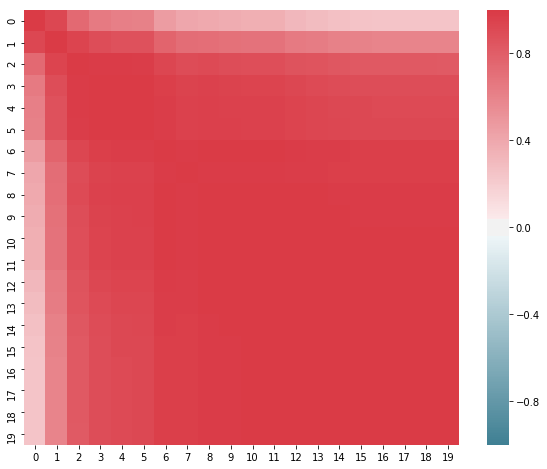

In [37]:
# Heatmap/Correlation Matrix
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_classifier.corr(), mask=np.zeros_like(df_classifier.corr(), dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, center=0, vmin=-1, vmax=1)